# Contour Extraction Algorithm

Author: Severin Kaderli - University of Bern <br>
Mail: severin.kaderli@students.unibe.ch

This algorithm extracts (closed) contour lines of two-dimensional gridded data. <br>
An xarray data set including the dimensions lat, lot at a specific time step is used as an input. <br>
The following features are implemented in the algorithm: <br />
* Extraction of all contours of a specific value. Unconnected contour parts are stored separately.
* Rescaling of the contour line to fit the resolution of the input field. Due to interpolation of the contour extraction tool, the resolution of the original contours is higher.
* Grouping of unclosed contours based on the start and end point. This is especially needed if overturnings of the contour line are present over the date border.
* The focus of the algorithm is to identify the single largest contour fully enclosing the pole. Therefore, the algorithm includes a filtering feature, which neglects contour segments smaller than a certain threshold. The size of a contour is defined by the extent of the contour segment in the longitudinal direction.

## Preparations

### Import packages

In [1]:
# for data
import xarray as xr

# for algorithm
import numpy as np
import itertools as itertools
from skimage import measure
from scipy import spatial
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.path as mpath
import matplotlib.patches as mpatches

### Load data and select time step

In [2]:
# load data
path = "/scratch3/severin/data/era5/pv/pv330_1979-2019.nc"
dataset = xr.open_dataset(path).isel(time=7510)

In [3]:
# specify names of coordinates
lat_name = "lat"
lon_name = "lon"
time_name = "time"
var_name = "pv"

### pre-process data

In [4]:
# get lon border
lon_border = [int(dataset[lon_name].values.min()), int(dataset[lon_name].values.max())]

## Functions of the Contour Extracting Algorithm

### Parameters
* "level": Specify the value of the contour line
* "x_extent": Specify min expansion of a single contour. A value of 1 means that the contour is present over all longitudes.
* "y_overlap": Specify in which interval (in degrees) in the y direction unclosed contours should be grouped together as long as they share the same longitude.
* "single": Specify if you only want to keep one (the largest) contour.
* "scale": Specify if the resolution of the contour points should be scaled to the resolution of the input field.

In [5]:
# enter parameters
level = 2
x_extent = 0.3 # in longitude percentage
y_overlap = 1 # in degrees
single = True
scale = True

### Define functions

In [6]:
# Subroutine 1
def ex_contours(dataset, level):
    """
    The extractions is based on the "find_contours" function of "measure" by "skimage".
    The output of the "find_contours" function is modified to obtain the original coordinates.
    The final output contains a list with entries each representing a single contour segment.
    
    Input:
    -----
    dataset: xarray
        xarray with two spatial dimensions but no time dimension
        
    level: float
        contour level
    
    Returns:
    -------
    list: arrays
        List with entries each representing a single contour segment
        
    """
    return [np.c_[contour[:,1]+min(lon_border),contour[:,0]] for contour in measure.find_contours(dataset[var_name].values,level)]

In [7]:
# Subroutine 2
def rescale_contours(contours, dataset):
    """
    Rescale the coordinates of the contour points. 
    The coordinates are fitted on a grid with the same resolution as the input field.
    
    Input:
    -----
    contours: list
        List with entries each representing a single contour segment
        
    dataset: xarray
        xarray with two spatial dimensions but no time dimension
    
    Returns:
    -------
    list: arrays
        List with entries each representing a single contour segment
    
    """
    x, y = np.meshgrid(dataset[lon_name],dataset[lat_name]) 
    x, y = x.flatten(), y.flatten()
    grid_points = np.vstack((x,y)).T 
    tree = spatial.KDTree(grid_points)

    contours_scaled = []
    for contour in contours:
        temp = []
        for point in contour:
            temp.append(grid_points[tree.query([point])[1][0]])
        unique = list(dict.fromkeys(map(tuple,temp)))
        contours_scaled.append(np.asarray(unique))
            
    return contours_scaled

In [8]:
# Subroutine 3
def group_contours(contours, y_overlap):
    """
    Group the contours according to their start and end point.
    Using the parameter "y_overlap" (in degrees), the interval representing the overlap region can be specified.
    
    Input:
    -----
    contours: list
        List with entries each representing a single contour segment
        
    y_overlap: float, optional
        Overlap in y direction in degrees in between unclosed contours at longitude border are grouped
    
    Returns:
    -------
    list: arrays
        List with entries each representing a single contour segment
    
    """
    contours_index = list(range(0,len(contours)))
    borders = []
    for contour,index in zip(contours,contours_index):
        stp = contour[0].tolist()
        ndp = contour[-1].tolist()
        borders.append([index]+stp+ndp)

    start = [[border[1],border[2]] for border in borders]
    end = [[border[3],border[4]] for border in borders]
    both = start+end
    
    for point in both:
        ind = [i for i, x in enumerate(both) if (x[0]==point[0] or all(i in [x[0],point[0]] for i in lon_border)) and point[1]-y_overlap <= x[1] <= point[1]+y_overlap]
        ind = np.mod(ind,len(contours))
        add = [borders[i][0] for i in ind]
        for i in ind:
            borders[i][0] = borders[min(add)][0]    

    all_values = [border[0] for border in borders]
    unique_values = set(all_values)

    contours_grouped = []
    for value in unique_values:
        this_group = []
        for border,contour in zip(borders,contours):
            if border[0] == value:
                this_group.append(contour)
        contours_grouped.append(this_group)
    
    contours_grouped_sorted = []
    for group in contours_grouped:
        if len(group) > 1:
            bigest = sorted(group, key=len, reverse=True)[0]
            rest = sorted(group, key=len, reverse=True)[1:]

            temp = [bigest]
            while len(rest) > 0:
                test = temp[-1][-1,1]
                for item,ind in zip(rest, range(0,len(rest))):
                    if test-y_overlap <= item[0,1] <= test+y_overlap:
                        temp.append(item)
                        break
                del rest[ind]
            contours_grouped_sorted.append(np.asarray(list(itertools.chain.from_iterable(temp))))
        else:
            contours_grouped_sorted.append(np.asarray(list(itertools.chain.from_iterable(group))))
            
        
    return contours_grouped_sorted

In [9]:
# Subroutine 4
def filter_contours(contours, dataset, x_extent):
    """
    The contours are filtered in respect to the previoulsy defined parameter "x_extent".
    
    Input:
    -----
    contours: list
        List with entries each representing a single contour segment
        
    dataset: xarray
        xarray with two spatial dimensions but no time dimension
        
    x_extent: float, optional
        Set minimal extent of a contour in the x direction. A coverage of all longitudes means x_extent = 1.
    
    Returns:
    -------
    list: arrays
        List with entries each representing a single contour segment
    
    """
    lons = dataset[lon_name].values
    contour_expansion = [len(np.unique(np.round(contour[:,0]))) for contour in contours]
    test_expansion = [expansion/len(lons) >= x_extent for expansion in contour_expansion]
    
    return list(itertools.compress(contours, test_expansion))

In [10]:
# Subroutine 5
def single_contours(contours, dataset, x_extent):
    """
    Select largest contour fully encircling the pole. 
    
    Input:
    -----
    contours: list
        List with entries each representing a single contour segment
        
    dataset: xarray
        xarray with two spatial dimensions but no time dimension
        
    x_extent: float, optional
        Set minimal extent of a contour in the x direction. A coverage of all longitudes means x_extent = 1.
    
    Returns:
    -------
    list: arrays
        List with entries each representing a single contour segment
    
    """
    lons = dataset[lon_name].values
    contour_expansion = [len(np.unique(np.round(contour[:,0]))) for contour in contours]
    test_expansion = [expansion/len(lons) >= x_extent for expansion in contour_expansion]

    if sum([i==1 for i in contour_expansion])>1: 
        mean_lat = [np.mean(contour[:,1]) for contour in contours]
        contours_single = contours[mean_lat.index(min(mean_lat))]
    else: 
        contours_single = contours[test_expansion.index(max(test_expansion))]

    return contours_single

In [11]:
def df_contours(contours):
    """
    Store final contour in a pandas data frame
    
    Input:
    -----
    contours: list
        List with entries each representing a single contour segment
    
    Returns:
    -------
    dataframe: float
        Dataframe with columns lon and lat
    
    """
    if type(contours)=="list":
        temp = np.asarray(list(itertools.chain.from_iterable(contours)))
    else:
        temp = contours
    return pd.DataFrame({'lon': temp[:,0].tolist(), 'lat': temp[:,1].tolist()})

### plot every process step for one time step

In [12]:
contours = ex_contours(dataset, level)
contours_scaled = rescale_contours(contours, dataset)
contours_grouped = group_contours(contours_scaled, y_overlap)
contours_filtered = filter_contours(contours_grouped, dataset, x_extent)
contours_single = single_contours(contours_filtered, dataset, x_extent)

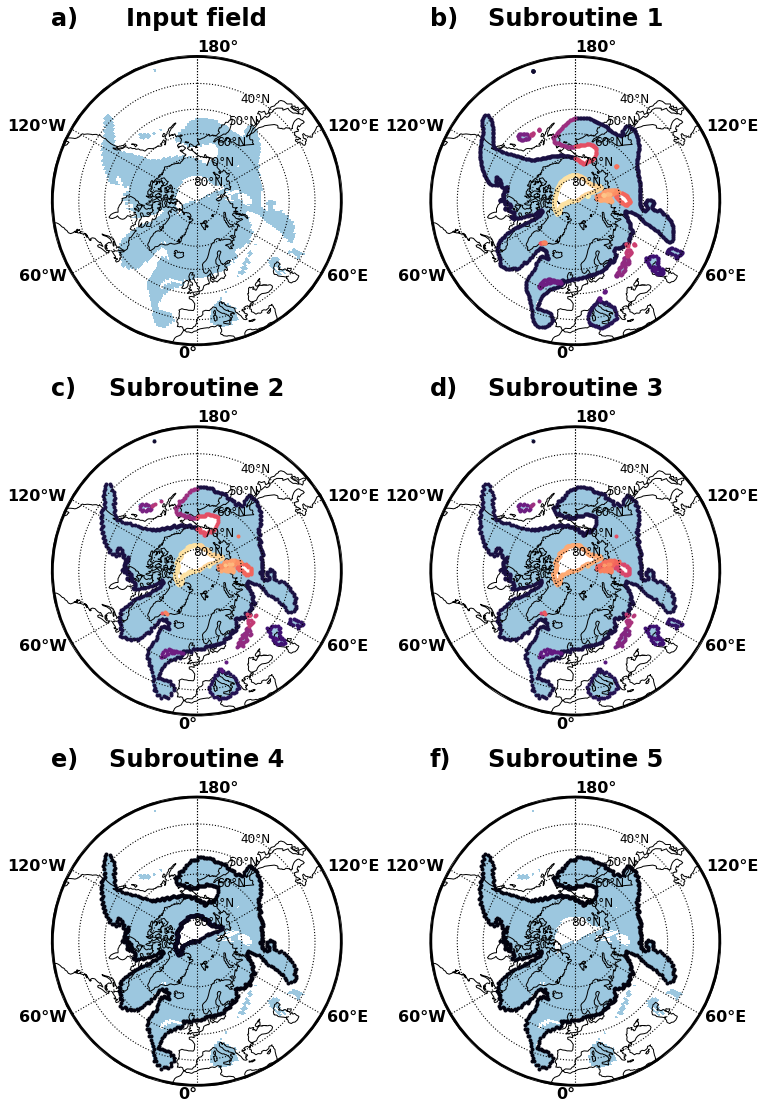

In [13]:
data_crs = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo()

fig, axes = plt.subplots(3,2, subplot_kw=dict(projection=proj), figsize=(12, 18))

pal_contours = "magma"
colors = sns.color_palette(pal_contours, n_colors=len(contours))

rgb_colors = ["#9CC7DF", "white"]

levels = [0,2,30]

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

line_wd = 2

plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                    right = 0.9,    # the right side of the subplots of the figure
                    bottom = 0.1,   # the bottom of the subplots of the figure
                    top = 0.9,      # the top of the subplots of the figure
                    wspace = 0.3,   # the amount of width reserved for blank space between subplots
                    hspace = 0.25    # the amount of height reserved for white space between subplots)
                   )

for ax in axes.flat:
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-180, 180, 30, 89], crs=data_crs)
    p0 = dataset[var_name].plot(ax=ax, colors=rgb_colors , add_colorbar=False, levels = levels, transform=data_crs)

data = [contours, contours_scaled, contours_grouped, contours_filtered, [contours_single]]
for ax,item in zip(axes.flat[1:],data):
    for contour, color in zip(item,colors):
        ax.plot(contour[:, 0], contour[:, 1],".", markersize=6, linewidth=line_wd, color = color, transform=data_crs)

titles = ["Input field",
          "Subroutine 1",
          "Subroutine 2",
          "Subroutine 3",
          "Subroutine 4",
          "Subroutine 5"]

number = ["a)", "b)", "c)", "d)", "e)", "f)"]

for ax,title,num in zip(axes.flat,titles, number):
    ax.set_title("")
    ax.set_title(title, fontweight='bold',fontsize=24, loc='center', y = 1.08)
    ax.set_title(num, fontweight='bold',fontsize=24, loc='left', y = 1.08)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_patch(mpatches.Circle((0.5, 0.5), radius=0.5, color='k', linewidth=5, fill=False, transform = ax.transAxes))
    gr = ax.gridlines(draw_labels=True, color="black", linestyle="dotted", linewidth = 1.1)
    gr.xlabel_style = {'size': 16, 'color': 'black', "rotation":0, "fontweight":"bold"}
    gr.ylabel_style = {'size': 12, 'color': 'black'}

plt.show()

## Combine all subfunctions to one algorithm

In [14]:
def extract_contour(dataset, level, y_overlap, x_extent, single, scale):
    
    """
    This function combines all subroutines
    
    Input:
    -----
    dataset: xarray
        xarray without time coordinate
        
    level: float
        contour level
        
    y_overlap: float, optional
        Overlap in y direction in degrees in between unclosed contours at longitude border are grouped
    
    x_expansion: float, optional
        Set minimal expansions of a contour in the x direction. A coverage of all longitudes means x_expansion = 1.
        
    single: boolean, optional
        Select if only one contour (largest with contour with smallest mean latitude) should be kept
    
    scale: boolean, optional
        Select if the contour should be rescaled on a grid with the same resolution as the input dataset
    
    Returns:
    -------
    dataframe: float
        Dataframe with columns lon and lat
        
    """
    
    contours = ex_contours(dataset, level)
    if scale == True:
        contours_scaled = rescale_contours(contours, dataset)
    else:
        contours_scaled = contours

    contours_grouped = group_contours(contours_scaled, y_overlap)
    contours_filtered = filter_contours(contours_grouped, dataset, x_extent)
    if single == True:
        contours_return = single_contours(contours_filtered, dataset, x_extent)
    else:
        contours_return = contours_filtered
    
    return df_contours(contours_return)

## Create simple plots

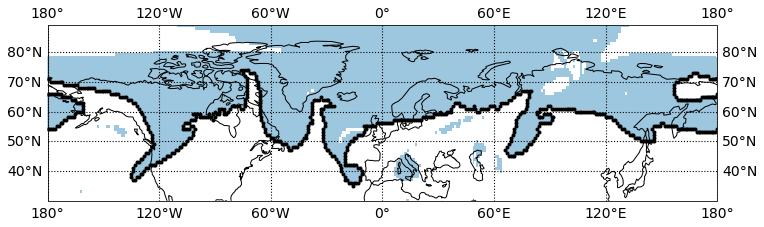

In [15]:
contour = extract_contour(dataset, level, y_overlap, x_extent, single, scale)

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=[12,12])
ax = plt.axes(projection=proj)

ax.plot(contour["lon"], contour["lat"], ".", color="black")
p0 = dataset[var_name].plot(ax=ax, colors=rgb_colors , add_colorbar=False, levels = levels)

ax.set_title("")
ax.set_aspect(1.6)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-180, 180, 30, 89], crs=data_crs)
#ax.set_boundary(circle, transform=ax.transAxes)
#ax.add_patch(mpatches.Circle((0.5, 0.5), radius=0.5, color='k', linewidth=5, fill=False, transform = ax.transAxes))
gr = ax.gridlines(draw_labels=True, color="black", linestyle="dotted", linewidth = 1.1)
gr.xlabel_style = {'size': 14, 'color': 'black'}
gr.ylabel_style = {'size': 14, 'color': 'black'}

plt.show()

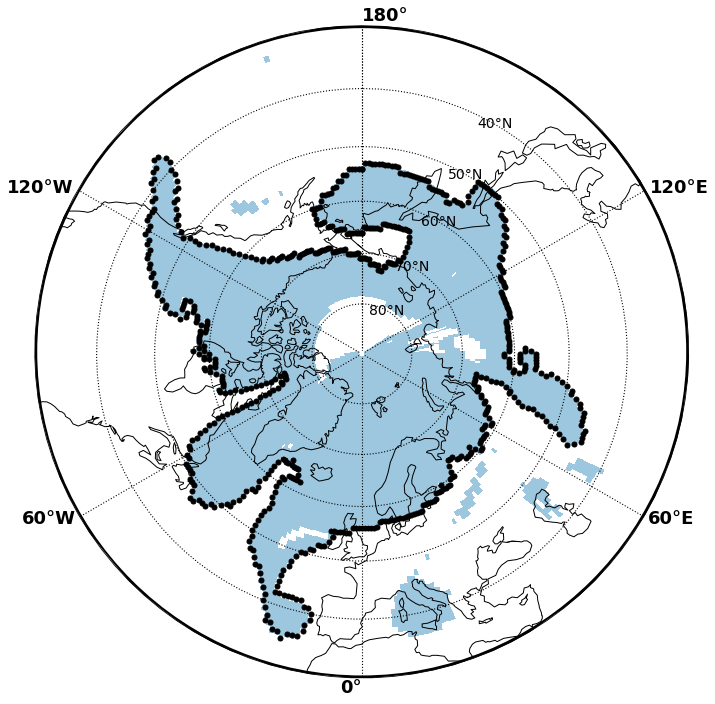

In [16]:
contour = extract_contour(dataset, level, y_overlap, x_extent, single, scale)

data_crs = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo()
fig = plt.figure(figsize=[12,12])
ax = plt.axes(projection=proj)

ax.plot(contour["lon"], contour["lat"], ".", color="black",transform = data_crs, markersize = 10)
p0 = dataset[var_name].plot(ax=ax, colors=rgb_colors , add_colorbar=False, levels = levels, transform=data_crs)

ax.set_title("")
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-180, 180, 30, 89], crs=data_crs)
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_patch(mpatches.Circle((0.5, 0.5), radius=0.5, color='k', linewidth=5, fill=False, transform = ax.transAxes))
gr = ax.gridlines(draw_labels=True, color="black", linestyle="dotted", linewidth = 1.1)
gr.xlabel_style = {'size': 18, 'color': 'black', "rotation":0, "fontweight":"bold"}
gr.ylabel_style = {'size': 14, 'color': 'black'}

plt.show()